BEFORE RUNNING THIS NOTEBOOK:

The tiles for training the first model can be downloaded from github in two zip files ('relabeled_tiles_pt1/2'), then unzipped and saved into a folder in the notebook directory called 'Relabeled_tiles'. Alternatively, if the notebook finds this folder empty, it will automatically download the tiles from Google Cloud (but it takes a few minutes).




In [1]:
!pip install datalab
!pip install --upgrade google-cloud-storage
from google.cloud import storage
import cv2
import math
import pandas as pd
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from geopy.distance import geodesic
import google.datalab.bigquery as bq
import json
import numpy as np

In [2]:
# Create needed folders and load Google credentials for GCP
if not os.path.exists('divided_documents'):
    os.makedirs('divided_documents')
if not os.path.exists('Relabeled_tiles'):
    os.makedirs('Relabeled_tiles')
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="elegant-weaver-287722-1c18abef2983.json"

In [3]:
# Check for needed json file and download from GCP if necessary
if not os.path.isfile('shipsnet.json'):
    print('fetching json...')
    storage_client = storage.Client("elegant-weaver-287722")
    # Create a bucket object
    bucket = storage_client.get_bucket('207_ais_project')
    blob = bucket.blob('json/shipsnet.json')
    filename = 'shipsnet.json'
    blob.download_to_filename(filename)
    print('done')

fetching json...
done


#IMAGE SPLIT FUNCTION

In [4]:
def cut_tiles(raw_image, dim):
  
  # adjustments for image irregularity -----manipulate at your peril----
  xspan_adj = .0335
  yspan_adj = .03
  #---------------------------------------------------------------------

  # raw image corner coordinates
  
  coords_1 = (37.783639, -122.415728)
  coords_2 = (37.783639, -122.320053 - xspan_adj)
  coords_3 = (37.783639, -122.415728)
  coords_4 = (37.736021 - yspan_adj, -122.415728)

  width = geodesic(coords_1, coords_2).m
  height = geodesic(coords_3, coords_4).m
  print(width)
  print(height)


  #kaggle scene
  img = raw_image


  width_pixel = width/img.shape[0]
  height_pixel = height/img.shape[1] 

  #EMPTY FOLDER
  import glob
  clear = 1

  if clear == 1:
    tile_files = 'divided_documents'
    filelist = [f for f in os.listdir(tile_files) if f.endswith(".png") ]
    for f in filelist:
      os.remove(os.path.join(tile_files, f))


  # Dim is the dimension of the images we want to split into
  dim = 80
  r_earth = 6371000.0 #radius of earth estimate in meters
  latitude, longitude = coords_1 #start from top left as the image is read right-down
  dx, dy = 0, 0
  lat_longs = {}


  for r in range(0,img.shape[0],dim):#latitude
      dy = height_pixel*r
      new_latitude = latitude - (dy / r_earth) * (180 / math.pi)
      for c in range(0,img.shape[1],dim):#longitude
          dx = width_pixel*c
          new_longitude = longitude + (dx / r_earth) * (180 /math.pi) / math.cos(latitude * math.pi/180)
          # uncomment the following line to save the split images
          cv2.imwrite(f"divided_documents/img{r}_{c}.png",img[r:r+dim, c:c+dim,:])
          # start from top left and go right and downward
          lat_longs[f"img{r}_{c}.png"] = (new_latitude, new_longitude)
        
  # os.getcwd()
  #images here: https://drive.google.com/drive/folders/1MZmtRpCeR0EtaI9eJTbfCLi8capvSUsQ?usp=sharing
#   test00 = plt.imread('divided_documents/img0_0.png')
  return(lat_longs)
raw_image = cv2.imread('sfbay_1.png')
dim = 80

#run function
lat_longs = cut_tiles(raw_image, dim)



5476.988450990182
8614.950171927141


In [5]:
def download_tiles():
    
    print('fecthing tiles...')
    storage_client = storage.Client("elegant-weaver-287722")
    # Create a bucket object
    bucket = storage_client.get_bucket('relabeled_tiles')
    
    prefix = 'Relabeled_tiles/'
    blobs = bucket.list_blobs(prefix=prefix)  # Get list of files
    for blob in blobs:
         filename = blob.name
         blob.download_to_filename(filename)
    print('done')

#SHIP/NO SHIP MODEL

In [6]:
data=json.load(open("shipsnet.json"))

In [7]:
data.keys()

dict_keys(['data', 'labels', 'locations', 'scene_ids'])

In [8]:
train=data["data"]
label=data["labels"]
ids = data["scene_ids"]

(4000, 80, 80, 3)


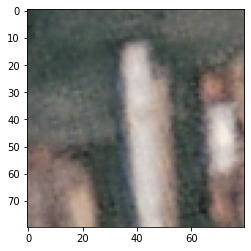

In [9]:
#Get training tiles for model
from os import listdir
from os.path import isfile, join
import re
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

# Check whether the folder of training tile folder exists and is populated
check_file = 'Relabeled_tiles/0__20150718_184300_090b__-122.35324421973536_37.772113980272394.png' 
isFile = os.path.isfile(check_file) 

#Download files if needed (this may take a while)
if isFile == False:
    download_tiles()

relabeled_tile_path = 'Relabeled_tiles'
files = [f for f in listdir(relabeled_tile_path) if isfile(join(relabeled_tile_path, f))]
x = []
y = []
for file in files:
  label = file.split('_')[0] 
  y.append(label)
  xtile = plt.imread(relabeled_tile_path + '/' + str(file))
  x.append(xtile)
  # print(xtile.shape)
# print(file)
x = np.array(x)
print(x.shape)
label = np.array(label)
plt.imshow(x[1])
plt.show()
x_flat = x.reshape(len(x),-1)
train_data, val_data, train_y, val_y = train_test_split(x_flat, y, test_size=0.2, random_state=43)
  

In [10]:
from sklearn.ensemble import RandomForestClassifier

sv=RandomForestClassifier(n_estimators=10)

sv.fit(train_data,train_y)

pre=sv.predict(val_data)

from sklearn.metrics import classification_report
print (classification_report(val_y,pre))

from sklearn.metrics import accuracy_score
print ("Accuracy:",accuracy_score(val_y,pre))


              precision    recall  f1-score   support

           0       0.82      0.90      0.86       426
           1       0.87      0.78      0.82       374

    accuracy                           0.84       800
   macro avg       0.85      0.84      0.84       800
weighted avg       0.84      0.84      0.84       800

Accuracy: 0.84125


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


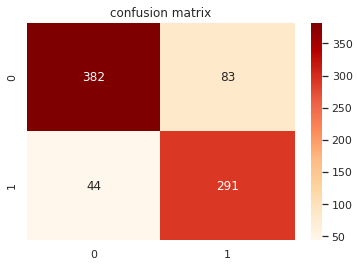

In [11]:
import sklearn
C2=sklearn.metrics.confusion_matrix(list(pre), list(val_y), sample_weight=None)
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['axes.unicode_minus'] = False
sns.set()
f,ax=plt.subplots()

sns.heatmap(C2,annot=True,ax=ax,cmap="OrRd", fmt='.20g') #heatmap
ax.set_title('confusion matrix') #title
plt.rcParams['font.sans-serif'] = ['SimHei']

# plt.savefig('filename_single.png',dpi=600)

#SHIP/NO SHIP MODEL WITH LIVE DATA

In [12]:
 #Collect full image tiles (not partials on the border)
 
mypath2 = 'divided_documents'
files2 = [f for f in listdir(mypath2) if isfile(join(mypath2, f))]
search_tiles = []
search_tile_labels = []

for file in files2:
    img2 = plt.imread(mypath2 + '/' + str(file))

    if img2.shape == (80, 80, 3):
        search_tiles.append(img2)
        search_tile_labels.append(str(file))
search_tiles = np.array(search_tiles)
# # plt.imshow(x2[3])
# # plt.show()
search_tiles_flat = search_tiles.reshape(len(search_tiles),-1)


In [13]:
pred = sv.predict(search_tiles_flat)
probs = sv.predict_proba(search_tiles_flat)
len(pred[pred != '0'])
hit_index = []
for i in range(len(pred)):
  if pred[i] == '1':
      # print(i)
      hit_index.append(i)
print(len(hit_index))
print(hit_index)

## INDEX BASED ON SELECTION OF SEARCH TILES (NOT FULL FOLDER)!!


30
[71, 72, 82, 117, 121, 142, 161, 178, 214, 250, 285, 302, 348, 355, 376, 424, 454, 464, 465, 468, 488, 497, 499, 503, 506, 593, 631, 644, 667, 698]


30


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


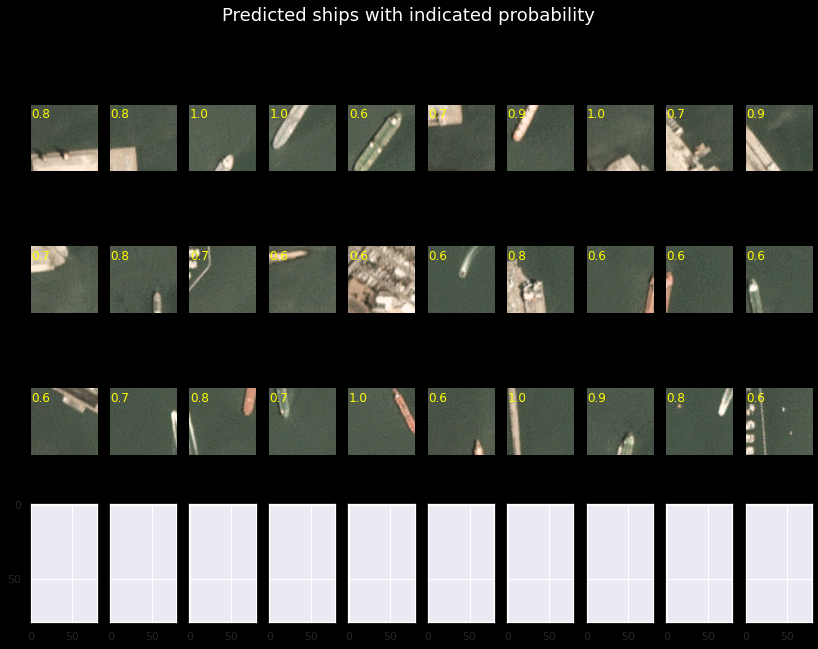

In [14]:
#Create list of tiles believed to contain ships
ship_tiles = []
for i in hit_index:
  ship_tiles.append(search_tile_labels[i])


#  Show predicted ship tiles with probability
print(len(hit_index))
fig, ax = plt.subplots(nrows = 1 + int(len(hit_index)/10), ncols = 10, sharex=True, sharey=True, figsize = (14, 10))
ax = ax.flatten()
for i in range(len(hit_index)):
    ax[i].imshow(search_tiles[hit_index[i]])
    ax[i].text(0,15,max(probs[hit_index[i]]), color = 'yellow' )
    ax[i].axis('off')
    ax[i].set(facecolor = 'black')
fig.suptitle("Predicted ships with indicated probability", fontsize=18, c = 'white')
fig.set_facecolor('black')
plt.show()

#AIS QUERY

In [15]:
#(function) build query for AIS

# 2016-08-31T00:00:00.000Z  to 2016-09-01T00:00:00.000Z

####Set ROUND value of RLAT, RLON to control coordinate precision
def make_query(vessel_num, ship_tiles, lat_longs):
  
  vessel_image = ship_tiles[vessel_num]

  # set parameters
  v_lat_long = lat_longs[vessel_image]
  lat = v_lat_long[0]
  lon = v_lat_long[1]

  #set minimum vessel length
  min_len = 200


  #set lat and lon tolerance (ideal range .005)
  lat_range = .005
  lon_range = .01
  #set image date (month, day, year)
  date = (7, 19, 2017)
  month, day, year = date
  #set time range if timestamp unknown (+/-; 0 for exact)
  day_range = 1
  month_range = 0
  year_range = 0

  print(v_lat_long)

  #build query
  a = 'SELECT DISTINCT VesselName, Callsign, VesselType, Month, Day, Year, Hour, Heading, Status, Length, RLAT, RLON, \
  FROM (SELECT *, FROM (SELECT *, EXTRACT(HOUR FROM BaseDateTime) AS hour, EXTRACT(DAY FROM BaseDateTime) AS day, EXTRACT(MONTH FROM BaseDateTime) AS month, EXTRACT(YEAR FROM BaseDateTime) AS year, \
  ROUND(LAT, 3) AS RLAT, ROUND(LON, 3) AS RLON, \
  FROM `elegant-weaver-287722.207Final.COMPOSITE_AIS`) WHERE day >= '            
  day_min = str(day - day_range)
  b = ' AND day <=  '
  day_max = str(day + day_range)
  c = ' AND month >= '
  month_min = str(month - month_range)
  d = ' AND month <= '
  month_max = str(month + month_range)
  e = ' AND year >= '
  year_min = str(year - year_range)
  f = ' AND year <= '
  year_max = str(year + year_range)
  g = ' AND LAT > '
  lat_min = str(lat - lat_range)
  h = ' AND LAT < '
  lat_max = str(lat + lat_range)
  i = ' AND LON > '
  lon_min = str(lon - lon_range)
  j = ' AND LON < '
  lon_max = str(lon + lon_range)
  k = ' AND Length > '
  min_len = str(min_len)
  l = ') LIMIT '
  limit = str(100000)

  query = a + day_min + b + day_max + c + month_min + d + month_max + e + year_min + f + year_max + g + lat_min + h + lat_max + i + lon_min + j + lon_max + k + min_len + l + limit
#   print(query)
  return(query)

#KNN SHIP IDENTIFICATION




In [16]:

def knn_id(ais_df, lat_longs, ship_tiles, vessel_num):
  if ais.empty:
    return('UNCONFIRMED VESSEL')
  
  #KNN Setup
  feature_set = ['RLAT', 'RLON']
  train_data = []
  for i in range (len(ais[['RLAT']])):
    features = []
    features.append(ais.at[i, feature_set[0]])
    features.append(ais.at[i, feature_set[1]])
    train_data.append(features)

  train_labels = []
  for i in range (len(ais[['VesselName']])):
    train_labels.append(ais.at[i,'VesselName'])

  dev_data = []
  inner_data = []
  inner_data.append(lat_longs[ship_tiles[vessel_num]][0])
  inner_data.append(lat_longs[ship_tiles[vessel_num]][1])
  dev_data.append(inner_data)

  #KNN
  knn = KNeighborsClassifier(n_neighbors = 5, p = 2, metric='minkowski')
  knn.fit(train_data, train_labels)
  y_pred = knn.predict(dev_data)
  # error = (dev_labels != y_pred).sum()/len(y_pred)
  return(y_pred)



In [17]:
# query
# https://marinecadastre.gov/ais/
# https://marinecadastre.gov/img/data-dictionary.jpg


vessel_num = 0
vessel_names = []

pd.set_option('display.max_rows', 1000000)

# general = 'SELECT * FROM `elegant-weaver-287722.207Final.COMPOSITE_AIS` LIMIT 10'
# query = general
for i in range(len(ship_tiles)):
# for i in range(2):
  vessel_num = i
  query = make_query(vessel_num, ship_tiles, lat_longs)

  df = bq.Query(query).execute().result().to_dataframe()
  try:
    ais = df[df['VesselName'].notnull()].reset_index()
  # print(ais['VesselName'].unique())
  # print(len(ais['VesselName']))
#   print(ais[['VesselName']])
  except KeyError:
    ais = pd.DataFrame()
  # ais
  try:
    name = knn_id(ais, lat_longs, ship_tiles, vessel_num)
  except ValueError:
    name = 'UNCONFIRMED VESSEL'
  print(name)
  vessel_names.append(name)

(37.75292280841646, -122.37925308423364)
UNCONFIRMED VESSEL
(37.75292280841646, -122.37644732148239)
UNCONFIRMED VESSEL
(37.75292280841646, -122.35119545672106)
['LIBERTY BAY']
(37.75072879473192, -122.35119545672106)
['LIBERTY BAY']
(37.75072879473192, -122.33997240571603)
['ASTRO PHOENIX']
(37.74853478104738, -122.37644732148239)
UNCONFIRMED VESSEL
(37.74853478104738, -122.328749354711)
UNCONFIRMED VESSEL
(37.746340767362845, -122.37364155873112)
UNCONFIRMED VESSEL
(37.7441467536783, -122.37083579597986)
['CAPE MOHICAN']
(37.74195273999376, -122.3680300332286)
['CAPE MOHICAN']
(37.739758726309226, -122.3680300332286)
['CAPE MOHICAN']
(37.739758726309226, -122.32594359195973)
UNCONFIRMED VESSEL
(37.779250972630926, -122.38486460973616)
UNCONFIRMED VESSEL
(37.73756471262469, -122.3680300332286)
['CAPE MOHICAN']
(37.73756471262469, -122.4016991862437)
UNCONFIRMED VESSEL
(37.774862945261845, -122.37083579597986)
['COMMANDER']
(37.774862945261845, -122.3820588469849)
['CAPE HUDSON']
(37.7

#DISPLAY

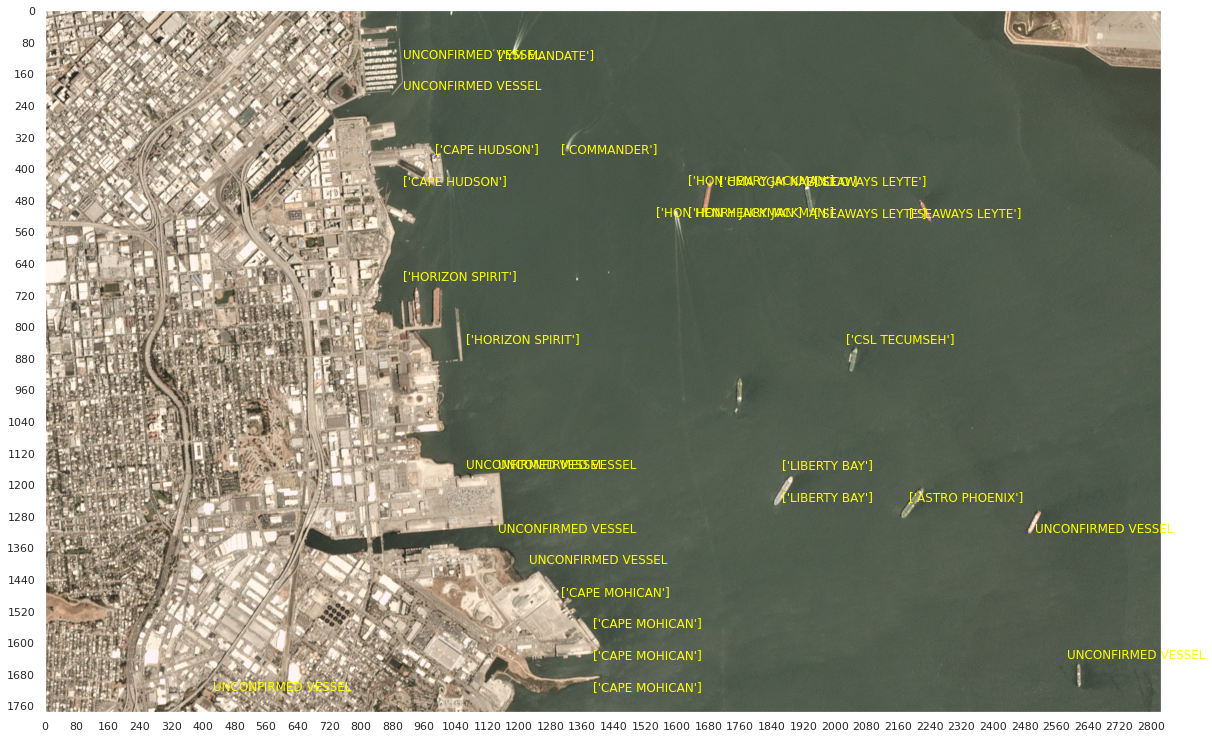

In [18]:
fig, ax = plt.subplots(figsize=(20,20))

for tile in range(len(ship_tiles)):
  y_num = int(ship_tiles[tile][3:].split('_')[0])
  x_num = int(ship_tiles[tile][3:].split('_')[1].split('.')[0])
  # print(ship_tiles[tile], x_num, y_num)
  ax.text(x_num + dim/3, y_num + dim/2,vessel_names[tile], color = 'yellow' )

grid_on = 0
ax.set_xticks(range(0, raw_image.shape[1], 80)) 
ax.set_yticks(range(0, raw_image.shape[0], 80)) 
if grid_on == 0:
    ax.grid(False) 

ax.imshow(plt.imread('sfbay_1.png'))
plt.show()

#save output
fig.savefig('output.png')